# Задания практикума 6

## Ход Работы для заданий 2, 3

Работа была выполнена на Python. Мною самостоятельно был написан код. Я прекрасно понимаю, что качество кода оставляет желать лучшего. Но в данном практикуме это, как написано, не оценивается, а лекция по numpy только через месяц.

In [2]:
# Импортируем все нужные библиотеки
import pandas as pd
import numpy as np
import requests, sys
from collections import Counter 
import matplotlib.pyplot as plt 
from numpy import log2, log
server = 'https://rest.ensembl.org' #Сайт, с которого получим последовательности

In [12]:
bases = ['A','T','G','C']

### Выбор хромосомы и прочтение таблицы с генами

Я выбрала хромосому X, прямую цепь.

In [13]:
chrN = 'X' 
strain = str(1)
expand_3prime = 0
expand_5prime = 0

GC = 0.396 # вручную достать из со страницы https://www.ncbi.nlm.nih.gov/genome/51
fr_gc = GC/2
fr_at=(1-GC)/2

#### Получим таблицу с информацией о 100 генах на Х хромосоме, длина которых больше 3000

In [459]:
df = pd.read_csv('human-genes.tsv', '\t')
# В таблице координаты начала первого кодона ATG указаны как Thickstart если на прямой цепи

##### Отберем последовательности для положительного и отрицательного контроля. Длина последовательностей должна быть 13. Для положительного контроля - последовательностей "7 + ATG + 3", для последовательности длиной 13 нуклеотидов, внутри которых есть ATG.

In [460]:
positive_df = df[(df['#chrom'] == 'chrX') & (df['strand'] == '+')]
positive_df['coords'] = (positive_df['thickStart']-6).astype(str).str.cat((positive_df['thickStart']+6).astype(str), sep ="..")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [462]:
# positive_df

In [120]:
negative_df = df[(df['#chrom'] == 'chrX') & (df['strand'] == '+') & (df['len'] >= 3000)].reset_index()
negative_df['coords'] = (negative_df ['thickStart']+200).astype(str).str.cat((negative_df ['thickStart']+400).astype(str), sep ="..")

#### Создание файлов с последовательностями для train, test, negative

In [463]:
with open ('train.txt', 'w') as train, open ('test.txt', 'w') as test:
    c = 0
    for coord in positive_df['coords']:
        ext = f"/sequence/region/human/{chrN}:{coord}:{strain}?expand_3prime={expand_3prime};expand_5prime={expand_5prime}"
        r = requests.get(server+ext, headers={ "Content-Type" : "text/x-fasta"})
        if (r.text.split()[1][7:10]) == 'ATG':
            if not r.ok:
                r.raise_for_status()
                sys.exit()
            if c < 40:
                c+=1
                print(r.text.split()[1], file = train)
            elif (c >= 40) and (c < 100):
                print(r.text.split()[1], file = test)
                c+=1
            else:
                break
        else:   
            pass
# берутся не рандомные последовательности, а идущие поочереди по списку таблицы df

Находим, где в 13нуклеотидных последовательностях внутри гена есть ATG. Внутри гена - от 187 нуклеотидов от начала гена. Расстояния может быть иным, не имеет значения, главное, что не начало гена.

In [ ]:
with open ('negative.txt', 'w') as neg:
    с = 0
    i = 0
    while c < 60:
        coord = negative_df.at[i,'coords']
        i += 1
        ext = f"/sequence/region/human/{chrN}:{coord}:{strain}?expand_3prime={expand_3prime};expand_5prime={expand_5prime}"
        r = requests.get(server+ext, headers={ "Content-Type" : "text/x-fasta"})
        if not r.ok:
            r.raise_for_status()
            sys.exit()
        t = r.text.split()[1]
        if 'ATG' in t:
            s = list(t.partition('ATG'))
            if (len(s[0]) >= 8) and (len(s[2]) >= 3):
                print (s)
                posl = s[0][-7::1] + s[1] + s[2][0:3]
                print(posl, file = neg)
                c+=1
            else:
                pass
        

#### Напишем функции, считающие PWM и IC

In [9]:
# функция, определяющая длину последовательностей (вдруг не 13 возьмем), создаем матрицу нужно размера для подсчёта PWM
def MT(file):
    with open (file, 'r') as f:
        MT = np.array([list(seq.strip()) for seq in f]).transpose()
    N = len(list(MT[0]))
    return N,MT


# функция, считающая количество нуклеотидов в колонке "выравнивания" последовательностей
def COUNT_BASES(MT):
    count_bases = {}
    for c, lst in enumerate(MT):
        res = {base: (list(lst)).count(base) for base in bases}
    #     list(lst), потому что lst - numpy array
        count_bases[c] = res
    return count_bases

In [10]:
# Подсчёт PWM
def PWM(count_bases):
    F_table = {}
    e = 0.25
    for i, d2 in count_bases.items():
        res = {}
        for base, count in d2.items():
            if (base == 'G') or (base == 'C'):
                fr = fr_gc
            elif (base == 'A') or (base == 'T'):
                fr = fr_at            
            pwm = round(log(((count+e)/(N+1))/fr),4)
            
            res[base] = pwm
        F_table[i+1] = res   
    return F_table


In [257]:
n, mt = MT('train.txt')
count_bases = COUNT_BASES(mt)
pwm = PWM(count_bases) 
PWM_TRAIN = pd.DataFrame.from_dict(pwm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log2


Чем больше IC(j), тем больше частоты букв в
колонке отличаются от ожидаемых, тем больше
информации в колонке

#### Найдем средний сигнал для последовательности по PWM

In [250]:
with open ('test.txt', 'r') as f:
    c = 0
    mean_test = []
    for line in f:
        line = line.strip()
        res = 0
        c+=1
        for pos,ch in enumerate(line):
            res += PWM_TRAIN.at[ch, pos+1] 
        mean_test.append(round(res,2))
# для каждой позиции буквы в строчке - найти ее в столбце индекса таблицы и для ее номера найти число. просуммировать в рез

In [251]:
with open ('negative.txt', 'r') as f:
    c = 0
    mean_negative = []
    for line in f:
        line = line.strip()
        res = 0
        c+=1
        for pos,ch in enumerate(line):
            res += PWM_TRAIN.at[ch, pos+1]
        mean_negative.append(round(res,2))

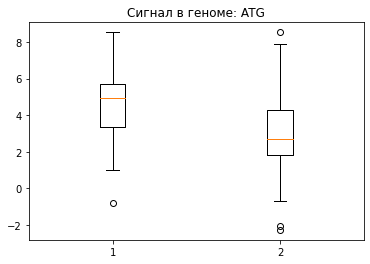

In [252]:
plt.boxplot([mean_test,mean_negative])
plt.title("Сигнал в геноме: ATG")
plt.savefig('signals.jpg')

##### Проверим насколько значимо получить такие отличия в положительном и отрицательном контроле, используя тест Манна-Уитни.

In [230]:
from scipy.stats import mannwhitneyu

In [253]:
U1, p = mannwhitneyu(mean_test,mean_negative)
p

2.1025444276229025e-05

#### Задание 3

In [7]:
def ICbj (count_bases_TEST,N):
    IC_table = {}
    for (i, d2) in count_bases_TEST.items():
        res = {}    
        for base, count in d2.items():
            if (base == 'G') or (base == 'C'):
                p = fr_gc        
            elif (base == 'A') or (base == 'T'):
                p = fr_at        
            f = count/N
            k = np.where(f/p <= 0, 0, f*log2(f/p))
            res[base] = round(float(k),3)      
        IC_table[i+1] = res       
    return IC_table
                         

In [14]:
n, mt = MT('./pr6/test.txt')
count_bases_TEST = COUNT_BASES(mt)
IC = ICbj(count_bases_TEST,n)
IC = pd.DataFrame.from_dict(IC)
IC

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


1      2      3      4      5      6      7      8      9      10  \
A -0.003 -0.087 -0.151 -0.104  0.554 -0.048 -0.104  1.727  0.000  0.000   
T -0.087 -0.151 -0.003 -0.157 -0.106 -0.003 -0.155  0.000  1.727  0.000   
G  0.028  0.490  0.055  0.055  0.028  0.003  0.055  0.000  0.000  2.336   
C  0.084 -0.020  0.215  0.447 -0.041  0.055  0.577  0.000  0.000  0.000   

      11     12     13  
A  0.022 -0.026 -0.157  
T -0.155 -0.157  0.293  
G  0.365 -0.099  0.115  
C  0.028  0.622 -0.076